In [14]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
# ensure that any edits to libraries you make are reloaded here automatically,
# and also that any charts or images displayed are shown in this notebook.


import numpy as np
import scipy as sc
import sklearn as sk
from sklearn import datasets, linear_model, model_selection
import pandas as pd
import datetime as dt

import matplotlib.pyplot as plt
import matplotlib #as mpl

np.set_printoptions(precision=2)
plt.rcParams['figure.figsize'] = [12, 8]


## settings
# min_days: only use counties which have data for the last min_days
# max_frac_missing: after filtering by min_days, only keep features with at most max_frac_missing
# is_pop_scale: whether to scale cases by population
# use_rel_counts: whether to pred counts/pop_size
# use_log_counts: whether to use log(counts), or log(counts/pop), as features and target
# use_counts_only # whether to use only counts as features (not used here since i try both)

cases_or_deaths = 'cases'
min_days = 7
max_frac_missing = 0.1
use_rel_counts = False
use_log_counts = False
#use_counts_only = False



## Load data into pd dataframes ##

# Replace non-ascii chars in files (some county names have accent mark)
counts_f = 'data/nyt-us-counties-cases-deaths.csv'
with open(counts_f) as f:
    lines = f.readlines()
with open(counts_f,'w') as f: # overwrite old file
    for line in lines:
        f.write(''.join([c if ord(c) < 128 else '_' for c in line]) )

# nyt case and death counts, where each date-county pair is a row
nyt_counts_df = pd.read_csv(counts_f)
nyt_counts_df['date'] = pd.to_datetime(nyt_counts_df['date'])

# load additional county-level data to use as features
interventions_df = pd.read_csv('data/jieyingwu_dates_interventions.csv') # ordinal dates
demographics_df = pd.read_csv('data/jieyingwu_demographics_counties.csv') # pop size, income, temp, etc


# make pivot df where each county is a row, with dates as columns
cases_df = pd.pivot_table(nyt_counts_df, values = 'cases', index=['fips','county','state'], columns = 'date').reset_index()
county_cols = cases_df.iloc[:,:3].copy()


# merge in additional features (case/death counts will be rightmost columns)
cases_df = interventions_df.merge(cases_df, left_on='FIPS', right_on='fips', suffixes=('_interventions', '_cases')) 
cases_df = demographics_df.merge(cases_df, left_on='FIPS', right_on='FIPS', suffixes=('_demog', '_cases')) 

#  # first 3 cols will be fips, county, state. rest are numeric data
not_fips_mask = [str(c).lower() != 'fips' for c in cases_df.columns]
cases_df = cases_df.loc[:,not_fips_mask] # remove redundant fips
cases_df = cases_df.select_dtypes(include='number') # numeric features only
cases_df = county_cols.join(cases_df)

# repeat for deaths
deaths_df = pd.pivot_table(nyt_counts_df, values = 'deaths', index=['fips','county','state'], columns = 'date').reset_index()
deaths_df = interventions_df.merge(deaths_df, left_on='FIPS', right_on='fips',suffixes=('_interventions', '_deaths')) 
deaths_df = demographics_df.merge(deaths_df, left_on='FIPS', right_on='FIPS', suffixes=('_demog', '_cases')) 

not_fips_mask = [str(c).lower() != 'fips' for c in deaths_df.columns]
deaths_df = deaths_df.loc[:,not_fips_mask] # remove redundant fips
deaths_df = deaths_df.select_dtypes(include='number') # numeric features only
deaths_df = county_cols.join(deaths_df)



In [20]:


## filter counties and features with missing data

X_df = None        # X_df will contain only counties and features which pass filters
if cases_or_deaths == 'cases':
    X_df = cases_df.copy()
else:
    X_df = deaths_df.copy()

counts_mask = [str(c)[:5] == '2020-' for c in X_df.columns] # bool which cols are counts

if use_rel_counts:
    pop_estimates = X_df['POP_ESTIMATE_2018'].values[:,None]
    X_df.iloc[:,counts_mask] = np.divide(1.0*X_df.iloc[:,counts_mask].values, pop_estimates)
    
if use_log_counts:
    X_df.iloc[:,counts_mask] = np.log(1.0*X_df.iloc[:,counts_mask].values)


# keep counties which have data from past 28 (or 0, etc) days
end = X_df.columns[-1] # target is last day
start = end - pd.DateOffset(min_days) 
rows_keep = ~X_df.loc[:,start:end].isna().any(axis=1)
X_df = X_df.loc[rows_keep,]


# keep columns which are >10% missing (lose a lot of prev dates if not filtering counties first)
keep_cols = X_df.columns[X_df.isnull().mean() < max_frac_missing]
X_df = X_df[keep_cols] 

# make target y (last day) and exclude from X_df
y = X_df.iloc[:,-1].values
y = y.reshape((-1,1))

X_df = X_df.iloc[:,:-1]
X_df # first 3 cols are fips,county,state, up



,fips,county,state,Rural-urban_Continuum Code_2013,Urban_Influence_Code_2013,Economic_typology_2015,POP_ESTIMATE_2018,N_POP_CHG_2018,Births_2018,Deaths_2018,...,2020-04-12 00:00:00,2020-04-13 00:00:00,2020-04-14 00:00:00,2020-04-15 00:00:00,2020-04-16 00:00:00,2020-04-17 00:00:00,2020-04-18 00:00:00,2020-04-19 00:00:00,2020-04-20 00:00:00,2020-04-21 00:00:00
0,1001.0,Autauga,Alabama,2.0,2.0,0.0,55601,158.0,655.0,532.0,...,19.0,19.0,23.0,25.0,25.0,26.0,25.0,27.0,28.0,30.0
1,1003.0,Baldwin,Alabama,3.0,2.0,5.0,218022,5403.0,2254.0,2228.0,...,71.0,78.0,87.0,98.0,102.0,103.0,109.0,114.0,117.0,123.0
2,1005.0,Barbour,Alabama,6.0,6.0,3.0,24881,-277.0,261.0,324.0,...,10.0,10.0,11.0,13.0,14.0,15.0,18.0,20.0,22.0,28.0
3,1007.0,Bibb,Alabama,1.0,1.0,0.0,22400,-155.0,250.0,256.0,...,16.0,17.0,17.0,19.0,24.0,23.0,26.0,28.0,32.0,32.0
4,1009.0,Blount,Alabama,1.0,1.0,0.0,57840,13.0,681.0,662.0,...,13.0,15.0,16.0,17.0,18.0,20.0,20.0,21.0,22.0,26.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2774,56035.0,Sublette,Wyoming,9.0,10.0,2.0,9813,54.0,97.0,60.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2775,56037.0,Sweetwater,Wyoming,5.0,8.0,2.0,43051,-496.0,546.0,303.0,...,7.0,9.0,9.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0
2776,56039.0,Teton,Wyoming,7.0,8.0,5.0,23081,-180.0,230.0,75.0,...,56.0,56.0,57.0,59.0,59.0,61.0,62.0,62.0,62.0,62.0
2777,56041.0,Uinta,Wyoming,7.0,8.0,2.0,20299,-157.0,276.0,147.0,...,4.0,4.0,4.0,4.0,4.0,6.0,6.0,6.0,6.0,6.0


In [21]:
## try linear model using prev counts in same county (whatever days left after filtering)
# now filter down X_df to counts
# TODO try predicting next day each county using prev day or week ago data from other counties

# X is array of features, will correspond to 'data'
# y is array 'target'

 # pd slicing includes last index
counts_mask = [str(c)[:5] == '2020-' for c in X_df.columns]
Xcounts_df = X_df.iloc[:,counts_mask]
X = Xcounts_df.values

# mask counties with missing values. would mask counties with missing y here
mask = ~np.isnan(X).any(axis=1) & ~np.isinf(X).any(axis=1) & ~np.isneginf(X).any(axis=1) 

# fit
regr = linear_model.LinearRegression() 
regr.fit(X[mask], y[mask])



def printTopCoefs(values, columns, nTop=None, includeBottom=False, maxPad=70):
    '''given values and corresponding descriptions in order, print top values'''
    col_valuesL = list( zip(list(columns), values.flatten().tolist()) )
    col_valuesL.sort(key=lambda tup: abs(tup[1]), reverse=True)

    p = max( [len(str(c)) for c in columns] ) + 1 # padding for print
    p = min(p, maxPad)
    if nTop == None:
        nTop = len(columns)
    for col, effect in col_valuesL[:nTop]:
        print('%s\t%10.5f' % ((str(col).ljust(p), effect)) )
    if includeBottom and nTop*2 > len(columns): 
        # print remaining entries without duplicates
        for col, effect in col_valuesL[nTop:]:
            print('%s\t%10.5f' % ((str(col).ljust(p), effect)) )
    elif includeBottom:
        print('...')
        for col, effect in col_valuesL[-nTop:]:
            print('%s\t%10.5f' % ((str(col).ljust(p), effect)) )        
    return


# print top coefficients - as expected, prev day has biggest effect
print('# Linear model on log(cases), using previous days counts')
printTopCoefs(regr.coef_, Xcounts_df.columns, nTop=None, includeBottom=True)



# Linear model on log(cases), using previous days counts
2020-04-18 00:00:00 	   1.26997
2020-04-21 00:00:00 	   1.21098
2020-04-19 00:00:00 	  -1.19278
2020-04-10 00:00:00 	   0.83907
2020-04-11 00:00:00 	  -0.59383
2020-04-13 00:00:00 	   0.51161
2020-04-12 00:00:00 	  -0.47306
2020-04-14 00:00:00 	  -0.36469
2020-04-20 00:00:00 	   0.26891
2020-04-17 00:00:00 	  -0.21185
2020-04-09 00:00:00 	  -0.18888
2020-04-16 00:00:00 	  -0.18773
2020-04-07 00:00:00 	   0.12180
2020-04-15 00:00:00 	   0.09784
2020-04-06 00:00:00 	  -0.07090
2020-04-08 00:00:00 	  -0.03859


In [23]:

## linear model: target against demographics, interventions, and counts in same county on previous days
# remake x_df to include these additional features
X = X_df.iloc[:,3:].values

# mask counties with missing values
# can also mask counties w missing y here
mask = ~np.isnan(X).any(axis=1) & ~np.isinf(X).any(axis=1) & ~np.isneginf(X).any(axis=1) 


regr = linear_model.LinearRegression() 
regr.fit(X[mask], y[mask])

#preds = regr.predict(test_data)
print('# Linear model of using demographics, interventions, previous days counts')
printTopCoefs(regr.coef_, X_df.iloc[:,3:].columns, nTop=10, includeBottom=True)

# overfitting
# ex/ using data up to april 12, top 3 coefficients land area, water area, total area with coefs +/- 52


# Linear model of using demographics, interventions, previous days counts
Fraction of Active Physicians Who Are Age 60 or Older 2018 (AAMC)     	 -76.79117
Fraction of Physicians Retained in State from Undergraduate Medical Education (UME) 2018 (AAMC)	  29.16311
Fraction of Active Physicians Who Are Female 2018 (AAMC)              	 -23.19356
Fraction of Residents in ACGME Programs Who Are IMGs as of December 31 2018 (AAMC)	  20.84025
Fraction of MD Students Matriculating In-State AY 2018-2019 (AAMC)    	 -14.65084
Fraction of Active Physicians Who Are International Medical Graduates (IMGs) 2018 (AAMC)	 -12.05618
R_birth_2018                                                          	  10.23592
R_death_2018                                                          	 -10.01514
R_NATURAL_INC_2018                                                    	  -9.98780
Oncology (Cancer) specialists (2019)                                  	  -4.66806
...
CI90UBINC_2018                                 

/home/lgai/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 263717.68725326896, tolerance: 194943.30523150603
  positive)
/home/lgai/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 263813.5113643359, tolerance: 194943.30523150603
  positive)
/home/lgai/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 264002.248851806, tolerance: 194943.30523150603
  positive)
/home/lgai/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the numb

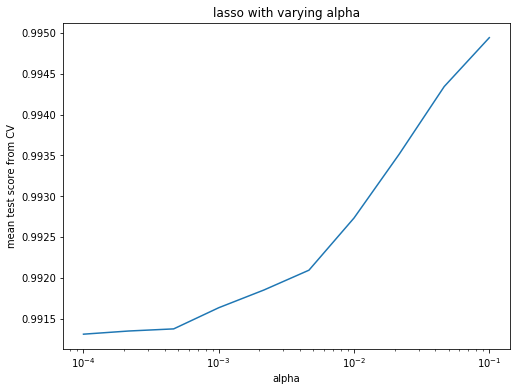

In [24]:
# try lasso
# choose alpha with cv (takes a few min, doesn't converge within 1000 iter)
# note: faster if random selecting coef to update, but less smooth. alpha = 1 was still best

regr = linear_model.Lasso(alpha=1.0, max_iter=5000,selection='cyclic')

alphas = np.logspace(-4, -1, 10)
tuned_parameters = [{'alpha': alphas}]
n_folds = 4

clf = model_selection.GridSearchCV(regr, tuned_parameters, cv=n_folds, refit=False)
clf.fit(X[mask], y[mask])
scores = clf.cv_results_['mean_test_score']
scores_std = clf.cv_results_['std_test_score']

fig, ax = plt.subplots(figsize=(8,6))
plt.semilogx(alphas, scores)
ax.set_title('lasso with varying alpha')
ax.set_ylabel('mean test score from CV')
ax.set_xlabel('alpha')
plt.show()  


In [26]:
# lasso, continued

# highest test score was at alpha = 1
# compare small, large alpha, and positive only
# note that increasing the iterations can change the coefficients pretty dramatically

coef_names = X_df.columns[3:]


print('# LASSO')
print('# varying max_iter at alpha=1.0')

regr = linear_model.Lasso(alpha=1.0,max_iter=5000)
regr.fit(X[mask], y[mask])
print('\n# alpha = 1.0 (L1), run for only 5k iter)')
printTopCoefs(regr.coef_, coef_names, nTop=10, includeBottom=False)

regr = linear_model.Lasso(alpha=1.0,max_iter=15000)
regr.fit(X[mask], y[mask])
print('\n# alpha = 1.0, run for 15k iter')
printTopCoefs(regr.coef_, coef_names, nTop=10, includeBottom=False)


regr = linear_model.Lasso(alpha=1.0,max_iter=50000)
regr.fit(X[mask], y[mask])
print('\n# alpha = 1.0, run for 50k iter')
printTopCoefs(regr.coef_, coef_names, nTop=10, includeBottom=False)


#print('\n# LASSO, positive restrain or low alpha')

regr = linear_model.Lasso(alpha=1.0, max_iter=15000, positive=True)
regr.fit(X[mask], y[mask])
print('\n# alpha = 1.0 and positive restraint, run for 15k iter')
printTopCoefs(regr.coef_, coef_names, nTop=10, includeBottom=False)


regr = linear_model.Lasso(alpha=0.0001, max_iter=15000)
regr.fit(X[mask], y[mask])
print('\n# alpha = 0.0001, run for 50k iter')
printTopCoefs(regr.coef_,coef_names, nTop=10, includeBottom=False)


    


# LASSO
# varying max_iter at alpha=1.0


/home/lgai/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 564200.6427762844, tolerance: 535636.4432119093
  positive)



# alpha = 1.0 (L1), run for only 5k iter)
Neurology (AAMC)                                                      	  -2.74593
General Surgery (AAMC)                                                	  -2.28617
Infectious Disease (AAMC)                                             	   2.12517
Oncology (Cancer) specialists (2019)                                  	  -2.05523
Endocrinology Diabetes and Metabolism specialists (2019)              	   2.02491
Radiology specialists (2019)                                          	   1.71101
Obstetrics & Gynecology Primary Care (2019)                           	   1.58801
Radiology & Diagnostic Radiology (AAMC)                               	  -1.43092
Pediatrics** (AAMC)                                                   	   1.34722
Ophthalmology (AAMC)                                                  	   0.88528

# alpha = 1.0, run for 15k iter
Obstetrics & Gynecology Primary Care (2019)                           	   1.66240
General Surgery (AAMC)

In [5]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Fit a bunch of linear models for log(cases) using 5-fold CV, compare avg MSE on validation set
# In general, lasso with alpha = 1 and restricted to non-neg coefficients does best, esp when using demographic data
# Models using only last 14 days do better than models using last 28 days and demographic data


from compare_models_functions import *

cases_df, deaths_df = load_county_datasets()


# make dataset including demographics, etc (can repeat with other settings)
print('Dataset including min 28 days, log counts, county level data and interventions')
X_df, X, y = filter_and_scale_data(cases_df, cases_or_deaths = 'cases', 
    use_last_n_days=28,  max_frac_missing=0.1, 
    use_rel_counts=False, use_log_counts = True, use_counts_only = False)

regrs, names = init_linear_models(train = False, do_OLS_only=False)

# run kfold cross validation
run_kfold2(regrs, names, X, y)


print('\nDataset including log counts, min 28 days only')


X_df, X, y = filter_and_scale_data(cases_df, cases_or_deaths = 'cases', 
        use_last_n_days= 28,  max_frac_missing=0.1, 
        use_rel_counts=False, use_log_counts = True, use_counts_only = True)

regrs28, names28 = init_linear_models(train = False, do_OLS_only=False)
run_kfold2(regrs28, names28, X, y)



print('\nDataset including min 14 days, log counts, county level data and interventions')
X_df, X, y = filter_and_scale_data(cases_df, cases_or_deaths = 'cases', 
    use_last_n_days=14,  max_frac_missing=0.1, 
    use_rel_counts=False, use_log_counts = True, use_counts_only = False)

regrs, names = init_linear_models(train = False, do_OLS_only=False)

# run kfold cross validation
run_kfold2(regrs, names, X, y)


print('\nDataset including min 14 days, log counts only')
X_df, X, y = filter_and_scale_data(cases_df, cases_or_deaths = 'cases', 
    use_last_n_days=14,  max_frac_missing=0.1, 
    use_rel_counts=False, use_log_counts = True, use_counts_only = True)

regrs, names = init_linear_models(train = False, do_OLS_only=False)

# run kfold cross validation
run_kfold2(regrs, names, X, y)

Dataset including min 28 days, log counts, county level data and interventions
MSE for OLS                                                  13063.06
MSE for LASSO_alpha1.0_max_iter5000                          57389.02
MSE for LASSO_alpha1.0_max_iter15k                           37697.08
MSE for LASSO_alpha1.0_max_iter50k                           37961.74
MSE for LASSO_alpha1.0_max_iter15k_positive                   5369.46
MSE for LASSO_alpha0.0001_max_iter5000                       56393.07

Dataset including log counts, min 28 days only


/home/lgai/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 489949.8305844016, tolerance: 394333.759172093
  positive)
/home/lgai/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 549029.0162442772, tolerance: 469017.92323280737
  positive)
/home/lgai/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 476682.0337103354, tolerance: 439019.0392979237
  positive)


MSE for OLS                                                   3189.89
MSE for LASSO_alpha1.0_max_iter5000                           5102.27
MSE for LASSO_alpha1.0_max_iter15k                            4556.05
MSE for LASSO_alpha1.0_max_iter50k                            4556.05
MSE for LASSO_alpha1.0_max_iter15k_positive                   2532.57
MSE for LASSO_alpha0.0001_max_iter5000                        4746.10

Dataset including min 14 days, log counts, county level data and interventions


/home/lgai/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 265651.8494531462, tolerance: 241543.381043299
  positive)


MSE for OLS                                                  11438.05
MSE for LASSO_alpha1.0_max_iter5000                          28410.55
MSE for LASSO_alpha1.0_max_iter15k                           19838.69
MSE for LASSO_alpha1.0_max_iter50k                           19802.11
MSE for LASSO_alpha1.0_max_iter15k_positive                   5533.73
MSE for LASSO_alpha0.0001_max_iter5000                       30653.97

Dataset including min 14 days, log counts only


/home/lgai/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 493572.27300304244, tolerance: 427347.22627036495
  positive)
/home/lgai/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 717957.917401915, tolerance: 391945.18388348946
  positive)
/home/lgai/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 560821.1692810958, tolerance: 391945.18388348946
  positive)
/home/lgai/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the numb

MSE for OLS                                                   1354.59
MSE for LASSO_alpha1.0_max_iter5000                           1806.78
MSE for LASSO_alpha1.0_max_iter15k                            1544.87
MSE for LASSO_alpha1.0_max_iter50k                            1313.32
MSE for LASSO_alpha1.0_max_iter15k_positive                   1341.21
MSE for LASSO_alpha0.0001_max_iter5000                        1562.09


/home/lgai/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 387663.58162181353, tolerance: 364578.13341094134
  positive)


Performing stepwise search to minimize aic
Fit ARIMA: (2, 2, 2)x(0, 0, 0, 0) (constant=True); AIC=904.585, BIC=918.802, Time=0.031 seconds
Fit ARIMA: (0, 2, 0)x(0, 0, 0, 0) (constant=True); AIC=924.615, BIC=929.354, Time=0.004 seconds
Fit ARIMA: (1, 2, 0)x(0, 0, 0, 0) (constant=True); AIC=913.024, BIC=920.132, Time=0.016 seconds
Fit ARIMA: (0, 2, 1)x(0, 0, 0, 0) (constant=True); AIC=907.908, BIC=915.016, Time=0.016 seconds
Fit ARIMA: (0, 2, 0)x(0, 0, 0, 0) (constant=False); AIC=922.993, BIC=925.362, Time=0.003 seconds
Fit ARIMA: (1, 2, 2)x(0, 0, 0, 0) (constant=True); AIC=911.591, BIC=923.439, Time=0.031 seconds
Fit ARIMA: (2, 2, 1)x(0, 0, 0, 0) (constant=True); AIC=904.698, BIC=916.546, Time=0.025 seconds
Fit ARIMA: (3, 2, 2)x(0, 0, 0, 0) (constant=True); AIC=905.973, BIC=922.559, Time=0.032 seconds
Fit ARIMA: (2, 2, 3)x(0, 0, 0, 0) (constant=True); AIC=905.985, BIC=922.571, Time=0.044 seconds
Fit ARIMA: (1, 2, 1)x(0, 0, 0, 0) (constant=True); AIC=909.504, BIC=918.981, Time=0.022 seco

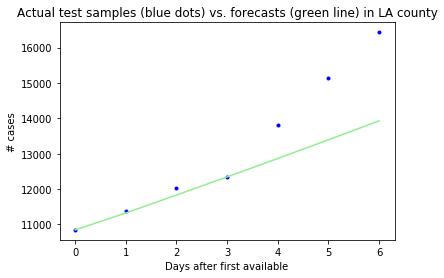

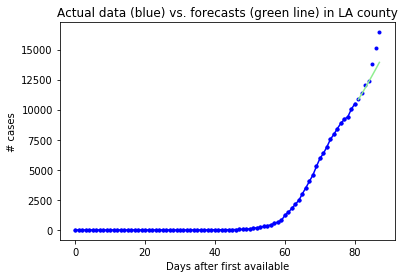

In [29]:
## arima model, fitting each county individually (only LA county for now)

# TODO combine arima with OLS? or arimax? 
# https://stats.stackexchange.com/questions/418259/arimax-vs-regression-with-arima-errors
# TODO add other counties as additional times series features
# TODO add test coverage as additional times series feature
# TODO run on multiple counties and average performance in terms of MSE, plot each curve

import pmdarima as pm
from pmdarima import model_selection
import numpy as np
from matplotlib import pyplot as plt

cases_or_deaths = 'cases'

# Load and fit count data for a single county at a time

i = int(np.where(cases_df['fips'] == 6037)[0]) # only do LA for now
counts_mask = [str(c)[:5] == '2020-' for c in cases_df.columns]
if cases_or_deaths == 'cases':
    data = np.array(cases_df.iloc[i,counts_mask].values, dtype='float')
else:
    data = np.array(deaths_df.iloc[i,counts_mask].values, dtype='float')
    
    
# data should be a 1d array of counts over time
first_nonmiss = np.where(~np.isnan(data))[0][0]
data = data[first_nonmiss:] 


train, test = model_selection.train_test_split(data, test_size=7) # test on last week

# fit model -- auto_arima automatically chooses parameters if not specified. can slow if d not set
arima_fitted = pm.auto_arima(train, error_action='ignore', trace=True,
                      suppress_warnings=True, maxiter=10, m=1)


print('Selected ARIMA order', arima_fitted.get_params()['order'])

# forecast
forecasts = arima_fitted.predict(n_periods=test.shape[0])  # predict N steps into the future

# Plot actual test vs. forecasts
x = np.arange(test.shape[0])  # here, x is date
plt.scatter(x, test, marker='.', color = 'blue')
plt.plot(x, forecasts, color = 'lightgreen')
plt.title('Actual test samples (blue dots) vs. forecasts (green line) in LA county')
plt.xlabel('Days after first available')
if use_log_counts:
    plt.ylabel('log( %s )' % cases_or_deaths)
else:
    plt.ylabel('# %s' % cases_or_deaths)
plt.show()



# same, but showing training data too
x = np.arange(data.shape[0])
plt.scatter(x, data, c='blue', marker='.')
plt.plot(x[:-7], train, c='blue', marker='.') # train line
plt.plot(x[-7:], forecasts, c='lightgreen') # forecast line
plt.title('Actual data (blue) vs. forecasts (green line) in LA county')
plt.xlabel('Days after first available')
if use_log_counts:
    plt.ylabel('log( %s )' % cases_or_deaths)
else:
    plt.ylabel('# %s' % cases_or_deaths)
plt.show()



In [ ]:
# TODO run rf, run LM, run LM with counts only vs log(counts) vs differenced

# X is array of features, will correspond to 'data'. TODO if dtype is object, x may be list
    # y is array 'target'
